1. Implemente os algoritmos Árvore de Decisão, Random Forest, AdaBoost e Perceptron usando uma interface semelhante ao Scikit-Learn. O algoritmo deve ser uma classe Python em uma biblioteca externa.

Dica: veja as implementações disponíveis em: https://github.com/python-engineer/MLfromscratch/tree/master/mlfromscratch 
2. Treine e avalie (de acordo com a métrica F1-Score), usando suas implementações por você, o problema de classificação binária a seguir: Heart Disease Dataset

3. Compare o resultado de sua implementação com as implementações do scikit learn (Decision Tree, Random Forest, AdaBoost, Gradient Boosting, Perceptron) em um grid search. Varie os hiper-parâmetros da implementação do scikit learn.

4. Crie e use um modelo de Bagging usando o scikit learn com 100 árvores de decisão. Compare os resultados de suas predições sobre o conjunto de teste com os resultados do melhor Random Forest obtido na Questão 3. 

In [1]:
from modelos.adaboost import Adaboost
from modelos.decision_tree import DecisionTree
from modelos.perceptron import Perceptron
from modelos.random_forest import RandomForest
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree
from sklearn import ensemble
from sklearn import linear_model
import pandas as pd
import numpy as np

In [2]:
heart = pd.read_csv('../datasets/heart.csv')

In [3]:
X = heart.iloc[:,0:-1].values
y = heart.iloc[:,-1].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8)

In [5]:
res = {}

In [6]:
# skl_modelos = {
#   'ada_skl': ensemble.AdaBoostClassifier(),
#   'dt_skl': tree.DecisionTreeClassifier(),
#   'per_skl': linear_model.Perceptron(),
#   'rf_skl': ensemble.RandomForestClassifier()
# }

meus_modelos = {
  'ada': Adaboost(),
  'dt': DecisionTree(),
  'per': Perceptron(),
  'rf': RandomForest()
}

In [7]:
for k,m in meus_modelos.items():
  m.fit(X_train, y_train)
  y_pred = m.predict(X_test)
  res[k] = f1_score(y_pred=y_pred, y_true=y_test)

In [8]:
params = [
  {
    'est__criterion': ['gini', 'entropy'],
    'est__splitter': ['best', 'random'],
    'est__min_samples_split': [0.5,2,3,4],
    'est__random_state': [42],
    'est': [tree.DecisionTreeClassifier()],
  },
  {
    'est__n_estimators': [50, 100, 150],
    'est__criterion': ['gini', 'entropy'],
    'est__min_samples_split': [0.5,2,3,4],
    'est__random_state': [42],
    'est': [ensemble.RandomForestClassifier()],
  },
  {
    'est__n_estimators': [25, 50, 75],
    'est__learning_rate': [0.5, 1.0, 1.5],
    'est__algorithm': ['SAMME', 'SAMME.R'],
    'est__random_state': [42],
    'est': [ensemble.AdaBoostClassifier()],
  },
  {
    'est__penalty': ['l2', 'l1', 'elasticnet', None],
    'est__alpha': [1e-4,1e-3,1e-2],
    'est__max_iter': [500,1000,2000],
    'est__random_state': [42],
    'est': [linear_model.Perceptron()],
  }
]

In [9]:
pipe = Pipeline([
  ('est', None)
])

In [10]:
grid_search = GridSearchCV(pipe, params, scoring='f1', cv=3, n_jobs=-1, return_train_score=True)

In [11]:
%%capture
grid_search.fit(X_train, y_train)

In [12]:
res_df = pd.DataFrame(grid_search.cv_results_)

In [13]:
res_df['model'] = res_df['param_est'].astype(str).str.split('(',1,True)[0]

In [14]:
for idx in res_df.groupby('model')['rank_test_score'].idxmin():
  res[res_df.iloc[idx, -1] + '_skl'] = res_df.iloc[idx, 19]

In [25]:
comp = pd.DataFrame(res, index=[0])

<AxesSubplot:>

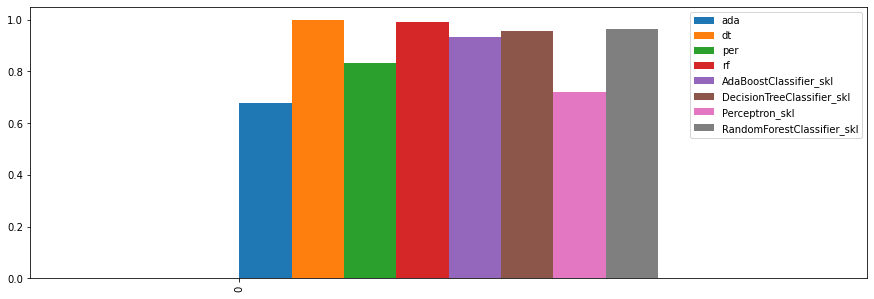

In [34]:
comp.plot.bar(figsize=(15,5), position=0.0)

In [35]:
my_rf = ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=100, random_state=42)

In [36]:
my_rf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=42)

In [37]:
y_pred = my_rf.predict(X_test)

In [38]:
res['my_rf'] = f1_score(y_pred=y_pred, y_true=y_test)

In [40]:
comp_rf = pd.DataFrame({'Random Forest': res['rf'], 'Meu RF': res['my_rf']}, index=[0])

<AxesSubplot:>

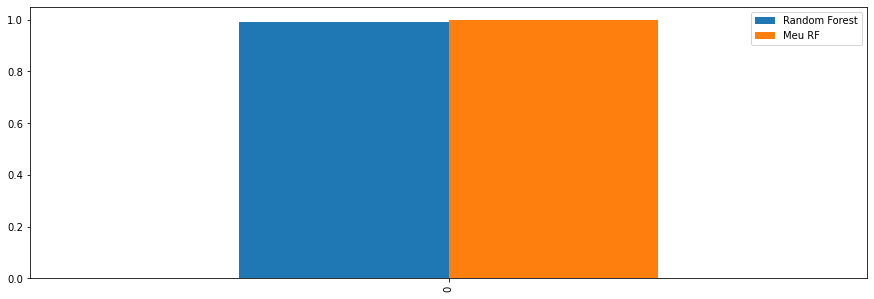

In [43]:
comp_rf.plot.bar(figsize=(15,5))